<a href="https://colab.research.google.com/github/man1sh1409/fakeNewsSocialMediaProspective/blob/master/Copy_of_RR_version_of_fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# feature Extraction code

#### install these module

In [ ]:
pip install -q transformers

In [ ]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### just import 

In [ ]:
import pandas as pd

In [ ]:
import re
import csv
import urllib.parse
from transformers import pipeline
import requests
import time
import json
import sys
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
csv.field_size_limit(sys.maxsize)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


131072

## helper function

In [ ]:
phising_url_mpp = dict()

In [ ]:
def preprocess_text(text):
  # Tokenize text
  tokens = word_tokenize(text)

  # Remove stopwords
  stop_words = set(stopwords.words('english'))
  filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

  # Lemmatize words
  lemmatizer = WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(word.lower()) for word in filtered_tokens]

  # Return preprocessed text
  return ' '.join(lemmatized_tokens)

In [ ]:
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov|edu|me)"
digits = "([0-9])"
multiple_dots = r'\.{2,}'

def split_into_sentences(text: str) -> list[str]:
    """
    Split the text into sentences.

    If the text contains substrings "<prd>" or "<stop>", they would lead 
    to incorrect splitting because they are used as markers for splitting.

    :param text: text to be split into sentences
    :type text: str

    :return: list of sentences
    :rtype: list[str]
    """
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    text = re.sub(multiple_dots, lambda match: "<prd>" * len(match.group(0)) + "<stop>", text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = [s.strip() for s in sentences]
    if sentences and not sentences[-1]: sentences = sentences[:-1]
    return sentences


In [ ]:
with open('/content/drive/MyDrive/dataset/phising-url/phising-url.csv', newline='') as csvfile:
  reader = csv.DictReader(csvfile)
  for i in reader:
    phising_url_mpp[i['url']]=int(i['score'])

In [ ]:
def phishing_url_score_fe(phising_url):
  API_key ='6874343ff58ee2ea10dae6ec40978e9647b03a1dbb72870295bcb540fd41738f'
  url = 'https://www.virustotal.com/vtapi/v2/url/report'
  res = []
  if phising_url in phising_url_mpp.keys():
    if phising_url_mpp[phising_url]!=900:
      return phising_url_mpp[phising_url]
  parameters = {'apikey': API_key, 'resource': url}
  try:
    time.sleep(16)
    response= requests.get(url=url, params=parameters,timeout=5)
    if response.status_code==200:
      json_response= json.loads(response.text)
      if json_response['response_code']==1:
        phising_url_mpp[phising_url]=json_response['positives']
      else:
        phising_url_mpp[phising_url]=90
    else:
      phising_url_mpp[phising_url]=90
  except:
    phising_url_mpp[phising_url]=900
  return phising_url_mpp[phising_url]

In [ ]:
phis_df=pd.read_csv('/content/drive/MyDrive/dataset/phising-url/phising-url.csv')

In [104]:
phis_df.sample(200)

,url,score
31,www.angeltherapy.com,1
193,www.crestwestwood.com,0
115,pjmedia.com,0
174,scotthuckabay.com,0
250,www.mannaorganicbakery.com,0
...,...,...
320,tigerstream.tv,0
405,www.njweedman.com,0
7,www.algore.com,0
431,ar.rt.com,0


## list of functions

In [ ]:
### Feature Extraction
    ## Complexity Features
        # 01. special_character <-
        # 02. upper_case <-
        # 03. lower_case <-
        # 04. short_sentences <-
        # 05. long_sentences <-
        # 06. question_marks <-
        # 07. exclamation_marks <-
    ## Stylometric Features
        # 08. adjective_count <-
        # 09. adverb_count <-
    ## 
        # 10. hyperlinks <-
        # 11. hyperlinks_diversity <-
        # 12. phising_score <-
        # 13. sensational_score <-
        # 14. sponsorship_score <-
        # 15. headline_content_symmetry_score <-

#### hyperlinks_fe

In [ ]:
def hyperlinks_fe(content, headline=""):
  headline_urls = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', headline)
  content_urls = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', content)
  
  mpp = dict()

  for i in headline_urls:
    domain = urllib.parse.urlparse(i).netloc
    if domain in mpp.keys():
      mpp[domain] += 1
    else:
      mpp[domain] = 1
  
  for i in content_urls:
    domain = urllib.parse.urlparse(i).netloc
    if domain in mpp.keys():
      mpp[domain] += 1
    else:
      mpp[domain] = 1
  HyperLink_Count = 0
  HyperLink_Diversity = 0
  Phising_Score= 0
  for i in mpp:
    HyperLink_Count += mpp[i]
    HyperLink_Diversity += (mpp[i] * mpp[i])
    Phising_Score += phishing_url_score_fe(i)*mpp[i]
  return [HyperLink_Count,HyperLink_Diversity,Phising_Score]


#### special_character_fe

In [ ]:
# 01. special_character

specialCharecters = "`~!@#$%^&*()_-+={}[]:;'<>,.?/\\|\""

def special_character_fe(content, headline=""):
  ans = 0
  for i in headline:
    if i in specialCharecters:
      ans += 1
  for i in content:
    if i in specialCharecters:
      ans += 1
  return ans

#### upper_case_fe

In [ ]:
# 02. upper_case
def upper_case_fe(content, headline=""):
  ans = 0
  # length=len(content)
  for i in headline:
    if i<='Z' and i>='A':
      ans += 1
  for i in content:
    if i<='Z' and i>='A':
      ans += 1
  return ans

#### lower_case_fe

In [ ]:
# 03. lower_case
def lower_case_fe(content, headline=""):
  ans = 0
  for i in headline:
    if i<='z' and i>='a':
      ans += 1
  for i in content:
    if i<='z' and i>='a':
      ans += 1
  return ans

#### length_sentences_fe
short long sentence

In [ ]:
# 04. short_sentences
# 05. long_sentences
def length_sentences_fe(content, headline=""):

  headline_sentences = split_into_sentences(headline)
  content_sentences = split_into_sentences(content)
  short_sentence_cnt = 0
  long_sentence_cnt = 0
  for i in headline_sentences:
    if len(i)<=15:
      short_sentence_cnt += 1
    else:
      long_sentence_cnt += 1
  for i in content_sentences:
    if len(i)<=15:
      short_sentence_cnt += 1
    else:
      long_sentence_cnt += 1
  return pd.Series([short_sentence_cnt, long_sentence_cnt])

#### question_marks_fe

In [ ]:
# 06. Question Marks

def question_marks_fe(content, headline=""):
  ans = 0
  for i in headline:
    if i=='?':
      ans += 1
  for i in content:
    if i=='?':
      ans += 1
  return ans

#### exclamation_marks_fe

In [ ]:
# 07. Exclamation Marks

def exclamation_marks_fe(content, headline=""):
  ans = 0
  for i in headline:
    if i=='!':
      ans += 1
  for i in content:
    if i=='!':
      ans += 1
  return ans

#### adj_and_adv_count_fe

In [ ]:
# 08. adjective_count

def adj_and_adv_count_fe(content, headline=""):
  adjective_cnt= 0
  adverb_cnt=0
  content_tokenized = sent_tokenize(content)
  for i in content_tokenized:
    content_token = word_tokenize(i)
    content_token = [w for w in content_token if not w in stop_words]
    content_tagged = pos_tag(content_token)
    for i in content_tagged:
      if i[1]=='JJ':
        adjective_cnt += 1
      if i[1]=='RB':
        adverb_cnt+=1

  headline_tokenized = sent_tokenize(headline)
  for i in headline_tokenized:
    headline_token = word_tokenize(i)
    headline_token = [w for w in headline_token if not w in stop_words]
    headline_tagged = pos_tag(headline_token)
    for i in headline_tokenized:
      if i[1]=='JJ':
        adjective_cnt += 1
      if i[1]=='RB':
        adverb_cnt+=1

  return pd.Series([adjective_cnt,adverb_cnt])

#### adverb_count_fe

In [ ]:
# 09. adverb_count

def adverb_count_fe(content, headline=""):
  RB_count = 0
  content_tokenized = sent_tokenize(content)
  for i in content_tokenized:
    content_token = word_tokenize(i)
    content_token = [w for w in content_token if not w in stop_words]
    content_tagged = pos_tag(content_token)
    for i in content_tagged:
      if i[1]=='RB':
        RB_count += 1

  headline_tokenized = sent_tokenize(headline)
  for i in headline_tokenized:
    headline_token = word_tokenize(i)
    headline_token = [w for w in headline_token if not w in stop_words]
    headline_tagged = pos_tag(headline_token)
    for i in headline_tokenized:
      if i[1]=='RB':
        RB_count += 1

  return RB_count

#### sentimental_score_fe
not working

In [ ]:
# 13. Sensational Score

def sentimental_score_fe(content, headline=""):
  sentiment_pipeline = pipeline("sentiment-analysis")
  return (sentiment_pipeline(headline+". "+content)[0]['score'])

#### sponsorship_score_fe

In [ ]:
# 14. sponsorship_score

sponsorship_words = ['adherent', 'advocacy', 'advocate', 'aegis', 'aid', 'alms', 'angel', 'atonement', 'auspices', 'backer', 'backing', 'bene-faction', 'benefactor', 'beneficence', 'bid', 'charity', 'contribution', 'egis', 'endeavor', 'essay', 'expiation', 'feeler', 'gift', 'godparent', 'grubstaker', 'guarantor', 'guardianship', 'hit', 'mainstay', 'oblation', 'offer', 'offered', 'offering', 'overture', 'pass', 'patron', 'patron', 'patronage', 'pitch', 'present', 'presentation', 'promoter', 'proposition', 'propoundment', 'protectorship', 'rendition', 'sacrifice', 'sponsor', 'submission', 'subscription', 'support', 'supporter', 'surety', 'sustainer', 'tender', 'tutelage', 'underwriter']
def sponsorship_score_fe(content, headline=""):
  headline_token = word_tokenize(headline)
  content_token = word_tokenize(content)
  text_stem = []
  sponsor_Word_cnt = 0
  lemmatizer = WordNetLemmatizer()
  for i in headline_token:
    text_stem.append(lemmatizer.lemmatize(i))
  for i in content_token:
    text_stem.append(lemmatizer.lemmatize(i))
  for i in text_stem:
    if i in sponsorship_words:
      sponsor_Word_cnt += 1
  return sponsor_Word_cnt

#### total_word_cnt_fe

In [ ]:
def total_word_cnt_fe(content,headline=""):
  return len(content.split())+len(headline.split())

#### headline_content_symmetry_score_fe

In [ ]:
# 15. headline_content_symmetry_score

def headline_content_symmetry_score_fe(content, headline=""):
  if headline=="":
    return 1.0

  preprocessed_text1 = preprocess_text(content)
  preprocessed_text2 = preprocess_text(headline)

  vectorizer = CountVectorizer().fit_transform([preprocessed_text1, preprocessed_text2])
  similarity = cosine_similarity(vectorizer)[0][1]
  return similarity

#### driver code of all upper function

In [ ]:
def add_feature(news):
  news['question_marks'] = question_marks_fe(news['headline'], news['content'])
  news['exclamation_marks'] = exclamation_marks_fe(news['headline'], news['content'])
  hyperLinks = hyperLinks_fe(news['headline'], news['content'])
  news['hyperlinks'] = hyperLinks[0]
  news['hyperlinks_diversity'] = hyperLinks[1]
  news['phising_score'] = hyperLinks[2]
  # news['sensational_score'] = sentimental_fe(news['headline'], news['content'])
  return news

In [ ]:
# Open files and extract feature

# trained_dataset = []
# id = 0

# with open('news.csv', newline='') as csvfile:
#   reader = csv.DictReader(csvfile)
#   for i in reader:
#     label = 0
#     if i['label']=='REAL':
#       label = 1
#     news = {'id':id, 'headline':i['title'], 'content':i['text'], 'label':label}
#     news = add_feature(news)
#     id += 1
#     trained_dataset.append(news)

# with open('train.csv', newline='') as csvfile:
#   reader = csv.DictReader(csvfile)
#   for i in reader:
#     news = {'id':id, 'headline':i['title'], 'content':i['text'], 'label':i['label']}
#     news = add_feature(news)
#     id += 1
#     trained_dataset.append(news)

# with open('True.csv', newline='') as csvfile:
#   reader = csv.DictReader(csvfile)
#   for i in reader:
#     news = {'id':id, 'headline':i['title'], 'content':i['text'], 'label':1}
#     news = add_feature(news)
#     id += 1
#     trained_dataset.append(news)

# print(trained_dataset)

# train the model

#### -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------




# model train

## imports for model training

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn import preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## importing dataset

In [ ]:
news_data=pd.read_csv('/content/drive/MyDrive/dataset/data-set-1/news.csv')

In [ ]:
news_data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
news_data.shape

(6335, 4)

##### other datasets imports

In [ ]:
df2=pd.read_csv('/content/drive/MyDrive/dataset/data-set-2/True.csv')

In [ ]:
df2.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
df2['label']=1

In [ ]:
df2.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
politi=pd.read_csv('/content/drive/MyDrive/dataset/political-data-set/politifact_fake.csv')

In [ ]:
politi.head()

,id,news_url,title,tweet_ids
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...


In [ ]:
df2['subject'].unique()

array(['politicsNews', 'worldnews'], dtype=object)

##### train_data

In [ ]:
train_data=pd.read_csv('/content/drive/MyDrive/dataset/data-set-1/train.csv')

In [ ]:
train_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \r\nAn Iranian woman has been sentenced ...,1


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [ ]:
train_data.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [ ]:
train_df=train_data.drop(columns=['author','id'])

In [ ]:
train_df.sample(5)

,title,text,label
14272,The Clintons and Soros launch America’s Purple...,Wayne MADSEN | 11.11.2016 | WORLD The Clintons...,1
19788,Songwriters Sue Justice Department Over Licens...,"When Michelle Lewis, a Los Angeles songwriter,...",0
12513,Moveable Feast Cafe 2016/11/11 … Open Thread,Leave a Reply Click here to get more info on f...,1
20476,James Comey Hearing Destroys Obstruction of Ju...,Former FBI director James Comey began his test...,0
4996,Dr. Duke & Andrew Anglin the True Voice of the...,http://mediaarchives.gsradio.net/dduke/112216....,1


In [ ]:
train_df.shape

(20800, 3)

In [ ]:
train_df.isnull().sum()

title    558
text      39
label      0
dtype: int64

In [ ]:
train_df=train_df.dropna()

In [ ]:
train_df.isnull().sum()

title    0
text     0
label    0
dtype: int64

In [ ]:
train_df.head()

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Print \r\nAn Iranian woman has been sentenced ...,1


In [ ]:
news_data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
news_df=news_data.replace({'label':{"FAKE":0,"REAL":1}})

In [ ]:
news_df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


In [ ]:
news_df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [ ]:
news_df.shape

(6335, 4)

In [ ]:
news_df.drop(columns=['Unnamed: 0'],inplace=True,axis=1)

In [ ]:
news_df.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


## dataset-1 is ready for feature extaction

#### concat dataset

In [ ]:
df_temp=[train_df,news_df]

In [ ]:
df_org=pd.concat(df_temp,ignore_index=True)

In [ ]:
df_org.head()

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Print \r\nAn Iranian woman has been sentenced ...,1


In [ ]:
df_features=df_org.drop(columns=['label'])

In [ ]:
df_features.head()

,title,text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ..."
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...
4,Iranian woman jailed for fictional unpublished...,Print \r\nAn Iranian woman has been sentenced ...


####  adding features

In [ ]:
df_features["Number of Words"] = df_features.apply(lambda x: total_word_cnt_fe(x['text'],x['title']),axis=1)

In [ ]:
df_features['HyperLink Count'],df_features['HyperLink Diversity'],df_features['Phising Score']=df_features.apply(lambda x:hyperlinks_fe(content = x['text'], headline = x['title']), axis=1,result_type='expand')


In [ ]:
df_features[['short_sentence_cnt', 'long_sentence_cnt']]=df_features.apply(lambda x:length_sentences_fe(content = x['text'],headline=x['title']),axis=1)

In [ ]:
df_features['Number of UpperCase']=df_features.apply(lambda x:upper_case_fe(x['text'],x['title']),axis=1)
df_features['Number of Specical-Symbol']=df_features.apply(lambda x:special_character_fe(x['text'],x['title']),axis=1)
df_features['Number of Question-Mark']=df_features.apply(lambda x:question_marks_fe(x['text'],x['title']),axis=1)
df_features['Number of Exclamation-Mark']=df_features.apply(lambda x:exclamation_marks_fe(x['text'],x['title']),axis=1)
df_features['Number of LowerCase']=df_features.apply(lambda x:lower_case_fe(x['text'],x['title']),axis=1)
df_features['Symmetric_Score']=df_features.apply(lambda x: headline_content_symmetry_score_fe(content = x['text'], headline = x['title']), axis=1)


In [ ]:
df_features['Sponsor Word Count']=df_features.apply(lambda x:sponsorship_score_fe(content = x['text'], headline = x['title']), axis=1)


In [ ]:
df_features[['adjective_cnt','adverb_cnt']]=df_features.apply(lambda x:adj_and_adv_count_fe(x['text'],x['title']),axis=1)


IndexError: ignored

In [ ]:
# check for all new columns values
df_features.iloc[:,2:]

,Number of Words,HyperLink Count,HyperLink Diversity,Phising Score,short_sentence_cnt,long_sentence_cnt,Number of UpperCase,Number of Specical-Symbol,Number of Question-Mark,Number of Exclamation-Mark,Number of LowerCase,Symmetric_Score
0,834,0,1,2,1,38,224,89,0,0,3799,0.498815
1,719,0,1,2,0,33,116,77,4,0,3212,0.268717
2,1273,0,1,2,1,53,232,184,4,0,5946,0.156456
3,567,0,1,2,1,27,140,51,0,0,2486,0.420980
4,168,0,1,2,0,6,22,16,0,0,807,0.458664
...,...,...,...,...,...,...,...,...,...,...,...,...
26533,653,0,1,2,1,27,153,99,0,1,3175,0.528148
26534,2193,0,1,2,1,61,485,383,1,0,11057,0.178891
26535,1956,0,1,2,0,105,441,214,6,0,9376,0.367657
26536,1131,0,1,2,0,50,239,158,0,0,5393,0.351885


In [ ]:
df_features.head()

In [ ]:
df_features.shape

(26538, 12)

In [ ]:
df_features['label']=df_org.iloc[:,-1:]

In [ ]:
# save csv file in drive
df_features.to_csv('/content/drive/MyDrive/dataset/newsWith15Features.csv')


In [ ]:
df_features.head()

##Extracted features dataset

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/dataset/newsWith12Features.csv')

In [ ]:
x_temp=df.iloc[:,:-1]

In [ ]:
df['Symetric Score']=df.apply(lambda x: headline_content_symmetry_score_fe(content = x['text'], headline = x['title']), axis=1)

In [ ]:
df.drop(columns=['Symetic Score'],inplace=True,axis=1)

In [ ]:
df.head()

,title,text,Number of Words,Number of UpperCase,Number of Specical-Symbol,Number of Question-Mark,Number of Exclamation-Mark,Number of LowerCase,Sponsor Word Count,Symetric Score,Adjective Count,Adverb Count,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,820,210,88,0,0,3748,1,0.498815,55,31,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,710,105,74,4,0,3179,2,0.268717,57,28,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1266,226,184,4,0,5925,5,0.156456,105,53,1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,557,130,51,0,0,2444,3,0.420980,36,10,1
4,Iranian woman jailed for fictional unpublished...,Print \r\nAn Iranian woman has been sentenced ...,154,21,16,0,0,728,0,0.458664,10,2,1


In [ ]:
df.shape

(26538, 13)

In [ ]:
df.isnull().sum()

title                         0
text                          0
Number of Words               0
Number of UpperCase           0
Number of Specical-Symbol     0
Number of Question-Mark       0
Number of Exclamation-Mark    0
Number of LowerCase           0
Sponsor Word Count            0
Symetric Score                0
Adjective Count               0
Adverb Count                  0
label                         0
dtype: int64

In [ ]:
df['label'].value_counts()

0    13551
1    12987
Name: label, dtype: int64

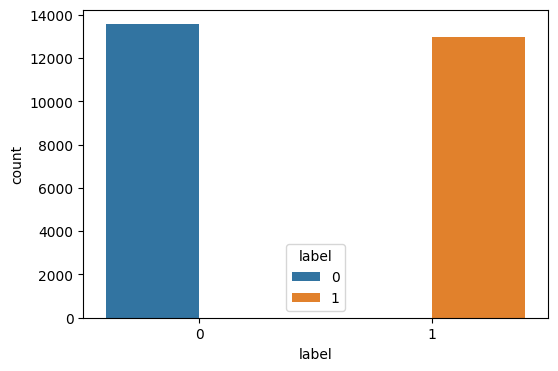

In [ ]:
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(4)
data_dist=sns.countplot(df,x='label',hue='label')
# plt.legend(['Fake',"Real"])
plt.savefig('/content/sample_data/data_dist.png')

In [ ]:

df_train=df.iloc[:,2:]

In [ ]:
df_train.head()

,Number of Words,Number of UpperCase,Number of Specical-Symbol,Number of Question-Mark,Number of Exclamation-Mark,Number of LowerCase,Sponsor Word Count,Symetric Score,Adjective Count,Adverb Count,label
0,820,210,88,0,0,3748,1,0.498815,55,31,1
1,710,105,74,4,0,3179,2,0.268717,57,28,0
2,1266,226,184,4,0,5925,5,0.156456,105,53,1
3,557,130,51,0,0,2444,3,0.420980,36,10,1
4,154,21,16,0,0,728,0,0.458664,10,2,1


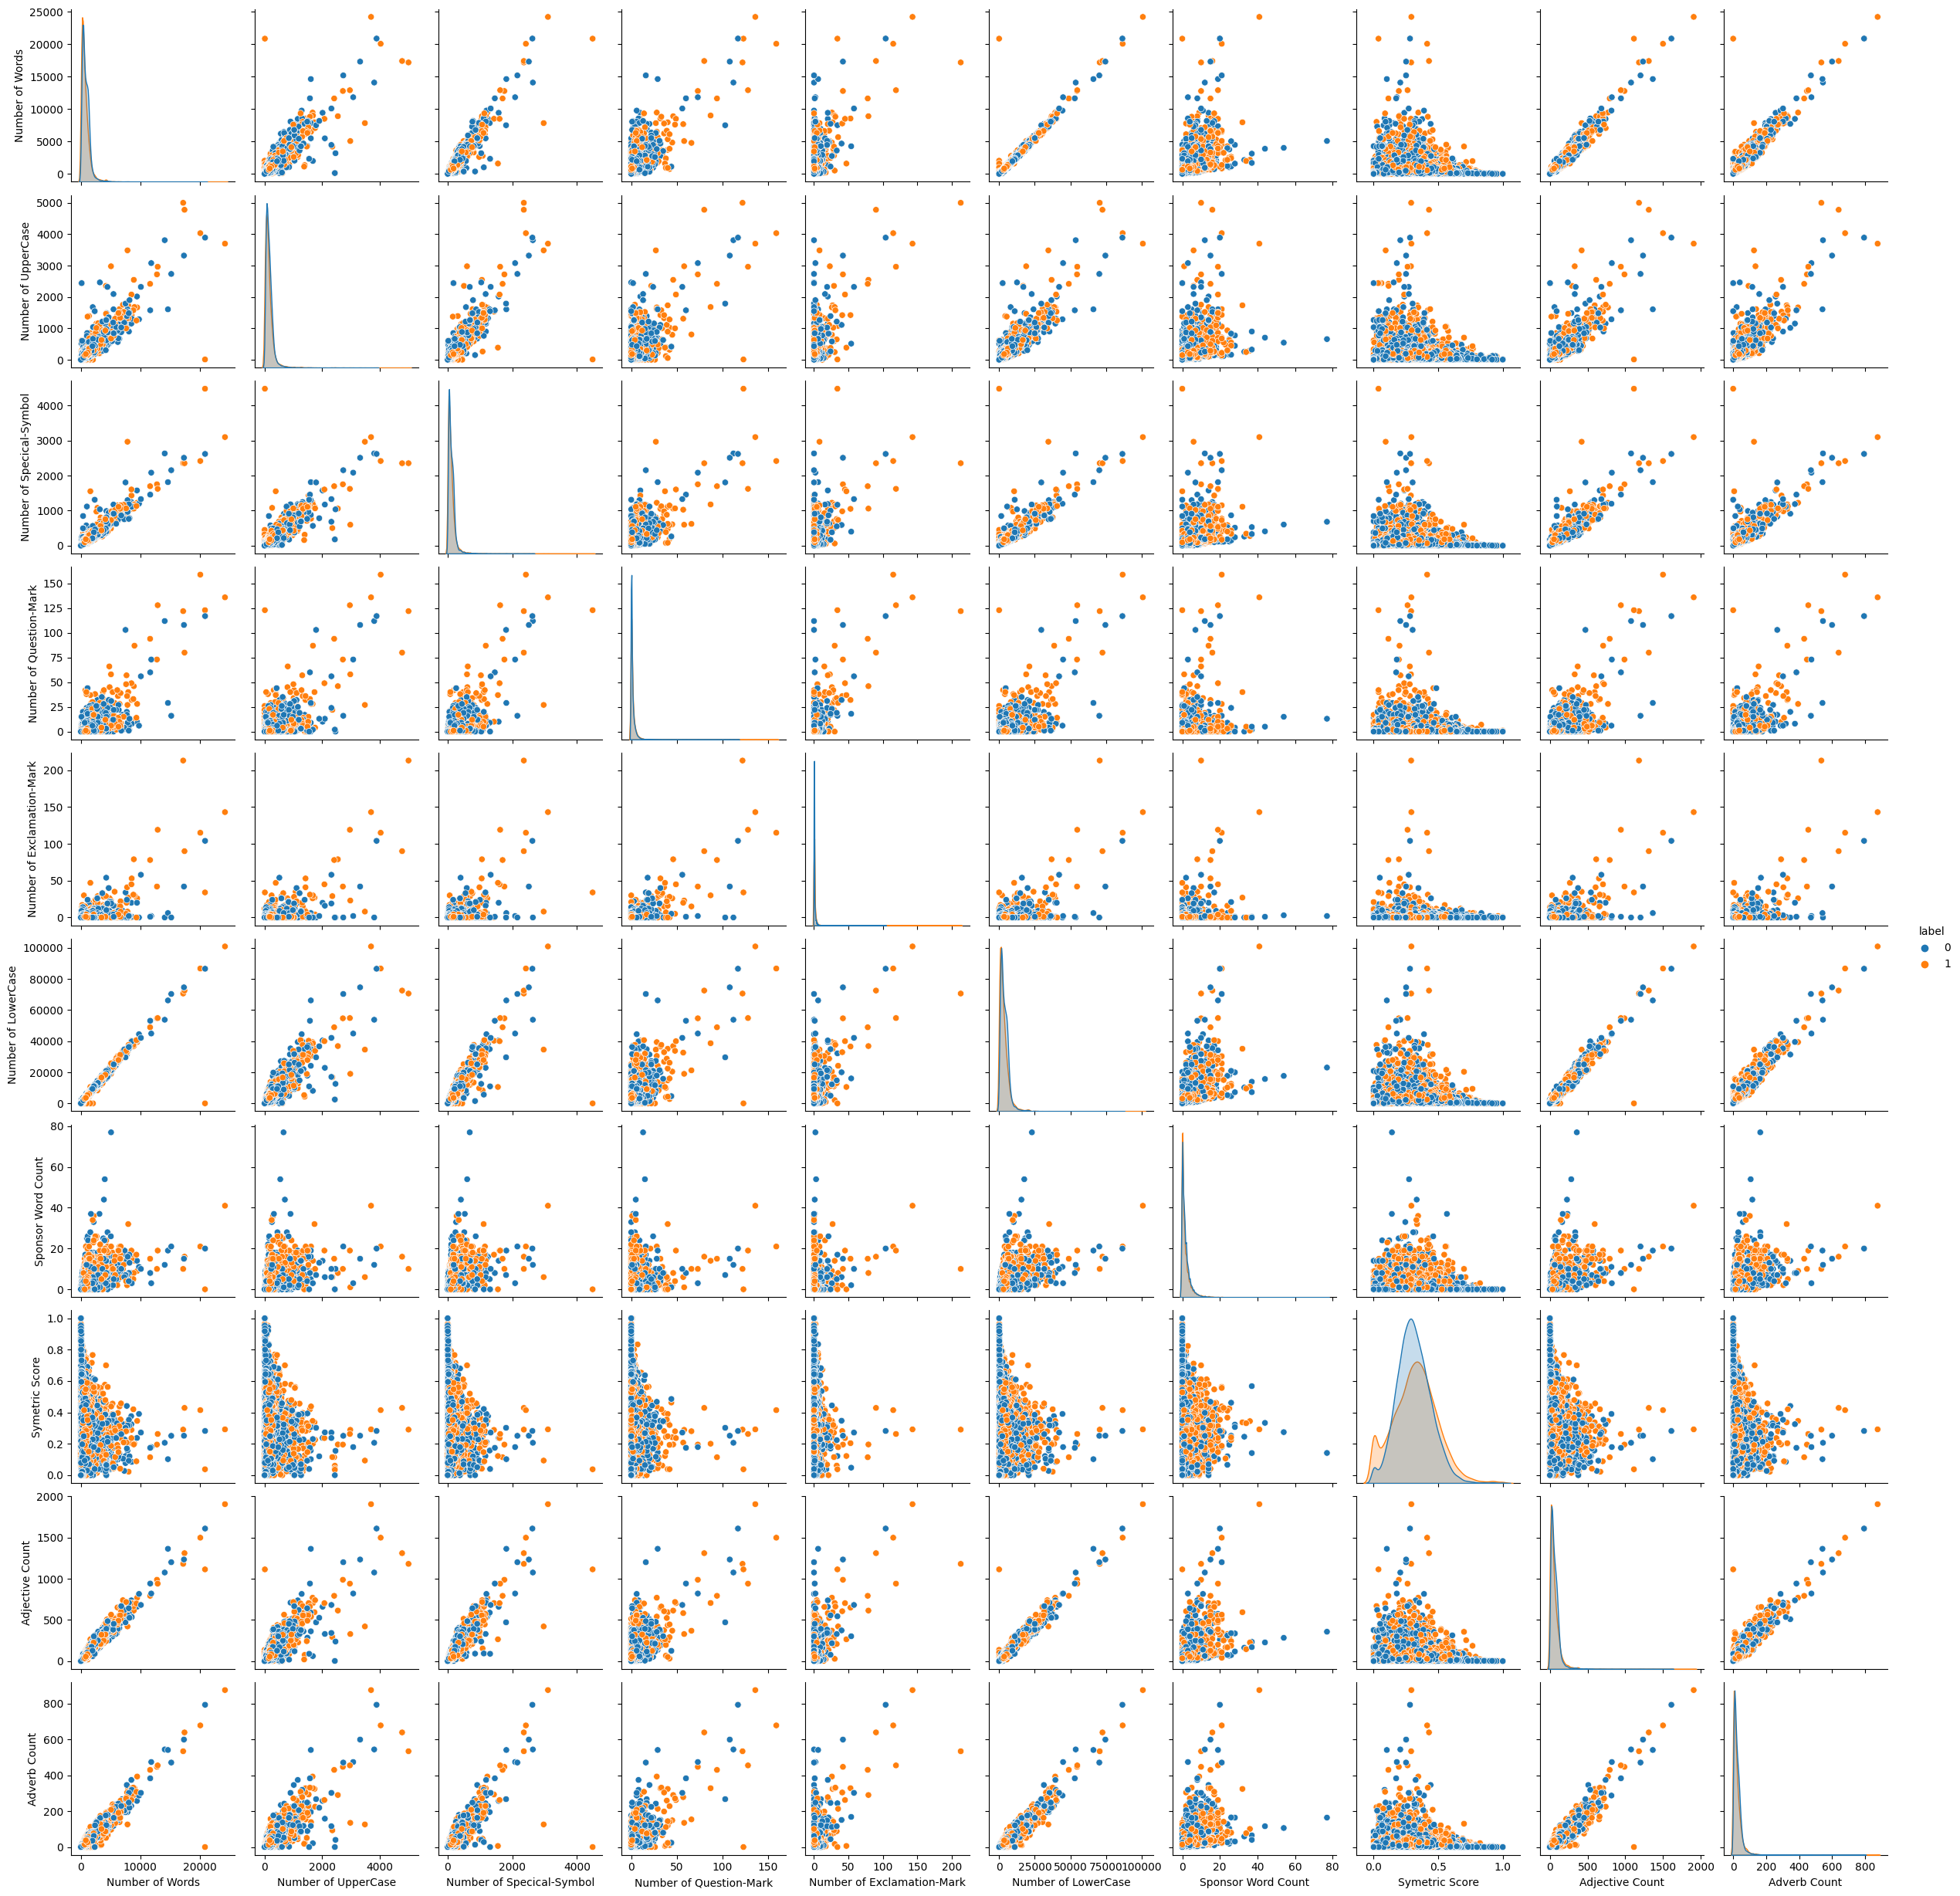

In [ ]:
pairplt=sns.pairplot(df_train,hue='label')


In [ ]:
df_train.corr()

,Number of Words,Number of UpperCase,Number of Specical-Symbol,Number of Question-Mark,Number of Exclamation-Mark,Number of LowerCase,Sponsor Word Count,Symetric Score,Adjective Count,Adverb Count
Number of Words,1.000000,0.881931,0.946639,0.626993,0.468289,0.984447,0.549027,-0.156479,0.972213,0.941034
Number of UpperCase,0.881931,1.000000,0.873987,0.591345,0.500006,0.886274,0.500648,-0.110875,0.845853,0.816742
Number of Specical-Symbol,0.946639,0.873987,1.000000,0.640773,0.448107,0.918845,0.513925,-0.168256,0.912390,0.871810
Number of Question-Mark,0.626993,0.591345,0.640773,1.000000,0.616912,0.577865,0.234394,-0.081790,0.592028,0.635037
Number of Exclamation-Mark,0.468289,0.500006,0.448107,0.616912,1.000000,0.434053,0.180348,-0.031764,0.436180,0.477665
Number of LowerCase,0.984447,0.886274,0.918845,0.577865,0.434053,1.000000,0.565632,-0.154834,0.974247,0.945170
Sponsor Word Count,0.549027,0.500648,0.513925,0.234394,0.180348,0.565632,1.000000,-0.086048,0.545844,0.506602
Symetric Score,-0.156479,-0.110875,-0.168256,-0.081790,-0.031764,-0.154834,-0.086048,1.000000,-0.155544,-0.149058
Adjective Count,0.972213,0.845853,0.912390,0.592028,0.436180,0.974247,0.545844,-0.155544,1.000000,0.931486
Adverb Count,0.941034,0.816742,0.871810,0.635037,0.477665,0.945170,0.506602,-0.149058,0.931486,1.000000


In [ ]:
X=df_train.iloc[:,:-1]
Y=df_train.iloc[:,-1:]

In [ ]:
X.head()

,Number of Words,Number of UpperCase,Number of Specical-Symbol,Number of Question-Mark,Number of Exclamation-Mark,Number of LowerCase,Sponsor Word Count,Symetric Score,Adjective Count,Adverb Count
0,820,210,88,0,0,3748,1,0.498815,55,31
1,710,105,74,4,0,3179,2,0.268717,57,28
2,1266,226,184,4,0,5925,5,0.156456,105,53
3,557,130,51,0,0,2444,3,0.420980,36,10
4,154,21,16,0,0,728,0,0.458664,10,2


In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()

In [ ]:
std_scaler=preprocessing.StandardScaler()


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [ ]:
x_train.shape

(21230, 10)

In [ ]:
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(21230, 1)
(5308, 10)
(5308, 1)


In [ ]:
x_train=std_scaler.fit_transform(x_train)
x_test=std_scaler.transform(x_test)

In [ ]:
x_train

array([[-0.02014318, -0.47829458, -0.18246032, ..., -0.24800647,
         0.35260519,  0.39386598],
       [-0.39696095,  2.79883406, -1.5617944 , ..., -0.25768915,
        -2.86635331, -2.07085065],
       [ 0.19171208, -0.0976587 ,  1.05104619, ..., -0.19573953,
        -0.18094628,  0.67072652],
       ...,
       [-0.24128775, -0.1593475 , -0.63571426, ..., -0.17056553,
         0.1823816 , -0.55255567],
       [-0.1625888 , -0.3067921 , -0.01559636, ..., -0.01015476,
         0.14368981, -0.70507127],
       [ 0.16019063, -0.07109523,  0.68214258, ..., -0.15308564,
        -0.61238194, -0.00778   ]])

In [ ]:
y_train=np.array(y_train['label'])

In [ ]:
lr=LogisticRegression()

In [ ]:
lr.fit(x_train,y_train)

LogisticRegression()

In [ ]:
y_pred=lr.predict(x_test)

In [ ]:
ac=accuracy_score(y_test,y_pred)
print('logReg score:',ac)

logReg score: 0.6230218538055765


In [ ]:
from sklearn.svm import SVC

In [ ]:
clf=SVC()

In [ ]:
clf.fit(x_train,y_train)

SVC()

In [ ]:
y_pred=clf.predict(x_test)

In [ ]:
ac=accuracy_score(y_test,y_pred)
print('svc score:',ac)

svc score: 0.6230218538055765


In [ ]:
#random forest
from sklearn.ensemble import RandomForestClassifier  
classifier= RandomForestClassifier()  
classifier.fit(x_train, y_train)  

RandomForestClassifier()

In [ ]:
y_pred=classifier.predict(x_test)

In [ ]:
ac=accuracy_score(y_test,y_pred)
print('random forest score:',ac)

random forest score: 0.625282592313489
